# Géométrie et espace de formes - TP3 - Construction d'atlas et attaches aux données géométriques

<br>
<br>

## 1. Exemples d'appariements difféomorphiques : points, mesures, varifolds

### a) Codes pour l'implémentation LDDMM

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [16, 10]

import torch
from torch.autograd import grad


# noyau gaussien (K(x,y)b)_i = sum_j exp(-|xi-yj|^2)bj
def GaussKernel(sigma):
    oos2 = 1/sigma**2
    def K(x,y,b):
        return torch.exp(-oos2*torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2))@b
    return K

# solveur d'ODE
def RalstonIntegrator(nt=10):
    def f(ODESystem,x0,deltat=1.0):
        x = tuple(map(lambda x:x.clone(),x0))
        dt = deltat/nt
        for i in range(nt):
            xdot = ODESystem(*x)
            xi = tuple(map(lambda x,xdot:x+(2*dt/3)*xdot,x,xdot))
            xdoti = ODESystem(*xi)
            x = tuple(map(lambda x,xdot,xdoti:x+(.25*dt)*(xdot+3*xdoti),x,xdot,xdoti))
        return x
    return f

# définition du Hamiltonien H(p,q)
def Hamiltonian(K):
    def H(p,q):
        return .5*(p*K(q,q,p)).sum()
    return H

# système hamiltonien à résoudre pour le shooting
def HamiltonianSystem(K):
    H = Hamiltonian(K)
    def HS(p,q):
        Gp,Gq = grad(H(p,q),(p,q), create_graph=True)
        return -Gq,Gp
    return HS

# shooting = intégration du système hamiltonien
def Shooting(p0,q0,K,deltat=1.0,Integrator=RalstonIntegrator()):
    return Integrator(HamiltonianSystem(K),(p0,q0),deltat)

# intégration des équations de flot
def Flow(x0,p0,q0,K,deltat=1.0,Integrator=RalstonIntegrator()):
    HS = HamiltonianSystem(K)
    def FlowEq(x,p,q):
        return (K(x,q,p),)+HS(p,q)
    return Integrator(FlowEq,(x0,p0,q0),deltat)[0]

# définition de la fonctionnelle à minimiser
def LDDMMloss(q0,K,dataloss,gamma=0.):
    def loss(p0):
        p,q = Shooting(p0,q0,K)
        return gamma * Hamiltonian(K)(p0,q0) + dataloss(q)
    return loss

# méthode d'optimisation générique
def Optimize(loss,args,niter=5):
    optimizer = torch.optim.LBFGS(args)
    print('performing optimization...')
    for i in range(niter):
        print("iteration ",i+1,"/",niter)
        def closure():
            optimizer.zero_grad()
            L = loss(*args)
            L.backward()
            return L
        optimizer.step(closure)
    print("Done.")
    return args

# fonction d'affichage du résultat pour des données landmarks ou nuages de points
def PlotRes2D(z,pts=None):
    def plotfun(q0,p0,Kv):
        p,q = Shooting(p0,q0,Kv)
        q0np, qnp = q0.data.numpy(), q.data.numpy()
        q0np, qnp, znp = q0.data.numpy(), q.data.numpy(), z.data.numpy()
        plt.plot(znp[:,0],znp[:,1],'.');
        plt.plot(q0np[:,0],q0np[:,1],'+');
        plt.plot(qnp[:,0],qnp[:,1],'o');
        plt.axis('equal');
        ng = 50
        a = np.min(np.vstack((q0np[:,0],qnp[:,0])))
        b = np.max(np.vstack((q0np[:,0],qnp[:,0])))
        c = np.min(np.vstack((q0np[:,1],qnp[:,1])))
        d = np.max(np.vstack((q0np[:,1],qnp[:,1])))
        sz = 0.2
        lsp1 = np.linspace(a-sz*(b-a),b+sz*(b-a),ng,dtype=np.float32)
        lsp2 = np.linspace(c-sz*(d-c),d+sz*(d-c),ng,dtype=np.float32)
        X1, X2 = np.meshgrid(lsp1,lsp2)
        x = np.concatenate((X1.reshape(ng**2,1),X2.reshape(ng**2,1)),axis=1)
        phix = Flow(torch.from_numpy(x),p0,q0,Kv).detach().numpy()
        X1 = phix[:,0].reshape(ng,ng)
        X2 = phix[:,1].reshape(ng,ng)
        plt.plot(X1,X2,'k',linewidth=.25);
        plt.plot(X1.T,X2.T,'k',linewidth=.25); 
        n,d = q0.shape
        nt = 20
        Q = np.zeros((n,d,nt))
        for i in range(nt):
            t = i/(nt-1)
            Q[:,:,i] = Shooting(t*p0,q0,Kv)[1].data.numpy()
        plt.plot(Q[:,0,:].T,Q[:,1,:].T,'y');
        if type(pts)!=type(None):
            phipts = Flow(pts,p0,q0,Kv).data
            plt.plot(phipts.numpy()[:,0],phipts.numpy()[:,1],'.b',markersize=.1);
    return plotfun

# fonction d'affichage pour des données de type surface triangulée
def PlotResSurf(VS,FS,VT,FT):
    def plotfun(q0,p0,Kv):
        fig = plt.figure();
        plt.axis('off')
        plt.title('LDDMM matching example')  
        p,q = Shooting(p0,q0,Kv)
        q0np, qnp = q0.data.numpy(), q.data.numpy()
        FSnp,VTnp, FTnp = FS.data.numpy(),  VT.data.numpy(), FT.data.numpy()    
        ax = Axes3D(fig, auto_add_to_figure=False)
        ax.plot_trisurf(q0np[:,0],q0np[:,1],q0np[:,2],triangles=FSnp,alpha=.5)
        ax.plot_trisurf(qnp[:,0],qnp[:,1],qnp[:,2],triangles=FSnp,alpha=.5)
        ax.plot_trisurf(VTnp[:,0],VTnp[:,1],VTnp[:,2],triangles=FTnp,alpha=.5)
        fig.add_axes(ax)
    return plotfun

### b) Fonctions d'attache aux données

<span style='color:blue'> Jusque là on s'est interessé au modèle de déformation : comment générer les diffeo ? 
    
La fonction d'attache aux données que on composait jusqu'à présent était définie comme $A(x) = \sum_i\|x_i - y_i \|^2$, seulement pour l'utiliser il faut avoir repéré des points d'interet, des points de correspondances dans les images : couteux. 
    
Qd le nbr de pts est différents d'un côté et de l'autre et qu'on n'a pas les correspondances, (on parle de points sets non ordonnés) $\implies$ on créé un modèle de mesure : 
    
ensemble de pts = combinaison de mesures de dirac : $\mu_x = frac{1}{n_x} \sum_i^{n_x} \delta_{x_i}$, $\mu_y = frac{1}{n_y} \sum_i^{n_y} \delta_{y_i}$ on construit une norme $\|\mu_x - \mu_y\|_{W'}^2 = \|\mu_x\|^2_{W'} + \|\mu_y\|^2_{W'} - 2 \scal{\mu_x}{\mu_y}_{W'}$ avec $\scal{\mu_x}{\mu_y}_{W'} = \frac{1}{n_x n_y} \sum_{i,j} K_w(x_i, x_j)$ duale sur l espace des mesures (equivalent a) : norme de hilbert sur l espace des fonctions. Si on fait ca, la norme de hilbert. </span>

defintiion du cente : $c_i = \frac{x_i +x_i + 1}{2}$ $\tau_i = x_{i+1} - x_i$ (tau_x c est le vecteur tangent unitaire) a chaque instant on associe a la courbe le varifold : c est une mesure sur les focntions definie sur $\mathbb{R}^d \times S^{d-1}$

$\mathcal C \longrightarrow [\mathcal C] le varifold associe$

$[\mathcal C](f) = \int_{\mathcal C} f(x, \overrightarrow{\tau_x}) dx$

norme de hilbert duale : $\|[x] - [y]\|_{W'}^2$ $\scal{[x]}{[y]}_{W'} = \sum_{i,j}K_e(x_i, y_j) K_t(\overrightarrow{\tau_i}, \overrightarrow{\tau_j})$
$[x]$ est une mesure associee a la courbe ou on regarde les points x_i et les vecteurs tangents associes \overrightarrow{\tau_x}

$\mathcal C \longrightarrow \{(x, \tau_x), x \in \mathcal C\}$

In [3]:
# fonction d'attache aux données pour des landmarks
def losslmk(z):
    def loss(q):
        return ((q-z)**2).sum()
    return loss

# fonction d'attache aux données pour des nuages de points via le modèle des mesures
def lossmeas(z,Kw):
    nz = z.shape[0]
    wz = torch.ones(nz,1)
    cst = (1/nz**2)*Kw(z,z,wz).sum()
    def loss(q):
        nq = q.shape[0]
        wq = torch.ones(nq,1)
        return cst + (1/nq**2)*Kw(q,q,wq).sum() + (-2/(nq*nz))*Kw(q,z,wz).sum()
    return loss


# noyau pour les varifolds (K(x,y,u,v)b)_i = sum_j exp(-|xi-yj|^2) <ui,vj>^2 bj
def GaussLinKernel(sigma,lib="keops"):
    oos2 = 1/sigma**2
    def K(x,y,u,v,b):
        Kxy = torch.exp(-oos2*torch.sum((x[:,None,:]-y[None,:,:])**2,dim=2))
        Sxy = torch.sum(u[:,None,:]*v[None,:,:],dim=2)**2
        return (Kxy*Sxy)@b
    return K


# fonction d'attache aux données pour les surfaces triangulées, modèle des varifolds
# VT: coordonnées des points de la surface cible
# FS,FT : indices des triangles des surfaces source et cible
# K : noyau varifold
def lossVarifoldSurf(FS,VT,FT,K):
    def CompCLNn(F,V):
        V0, V1, V2 = V.index_select(0,F[:,0]), V.index_select(0,F[:,1]), V.index_select(0,F[:,2])
        C, N = .5*(V0+V1+V2), .5*torch.cross(V1-V0,V2-V0)
        L = (N**2).sum(dim=1)[:,None].sqrt()
        return C,L,N/L
    CT,LT,NTn = CompCLNn(FT,VT)
    cst = (LT*K(CT,CT,NTn,NTn,LT)).sum()
    def loss(VS):
        CS,LS,NSn = CompCLNn(FS,VS)
        return cst + (LS*K(CS,CS,NSn,NSn,LS)).sum() - 2*(LS*K(CS,CT,NSn,NTn,LT)).sum()
    return loss


# fonction similaire pour les courbes
def lossVarifoldCurve(FS, VT, FT, K):
    # correspondances :
    # pts :
    # tangents :
    def get_center_length_tangents(F, V):
        V0, V1 = V.index_select(0, F[:, 0]), V.index_select(0, F[:, 1])
        centers, tangents = .5*(V0+V1), V1-V0
        length = (tangents**2).sum(dim=1)[:, None].sqrt()
        return centers, length, tangents / length
    CT, LT, TTn = get_center_length_tangents(FT, VT)
    cst = (LT * K(CT, CT, TTn, TTn, LT)).sum()
    def loss(VS):
        CS, LS, TSn = get_center_length_tangents(FS, VS)
        return cst + (LS * K(CS, CS, TSn, TSn, LS)).sum() - 2 * (LS * K(CS, CT, TSn, TTn, LT)).sum()
    return loss

### Exemple de matching de landmarks - données "poissons" du TP 2

In [ ]:
# on charge les données
pts1, pts2, lmk1, lmk2 = torch.load('fish.pt')

# définition des points q0 = landmarks du premier poisson
q0 = lmk1.clone().detach().requires_grad_(True)

# définition du noyau Kv
Kv = GaussKernel(sigma=.25)

# terme d'attache aux données
Dataloss = losslmk(lmk2)

# fonction globale à minimiser
loss = LDDMMloss(q0,Kv,Dataloss)

# initialisation des vecteurs moments p0
p0 = torch.zeros(q0.shape, requires_grad=True)

# optimisation de p0
p0, = Optimize(loss,[p0])

# affichage du résultat
plotfun = PlotRes2D(lmk2,pts1)
plotfun(q0,p0,Kv)
plt.show()

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


### Exemple de matching de mesures

In [ ]:
# exemple synthétique pour le modèle de mesures
VS, _, VT, _ = torch.load('curves.pt')
VS.requires_grad = True
q0 = VS
Kv = GaussKernel(sigma=.5)
Dataloss = lossmeas(VT,GaussKernel(sigma=.5))
loss = LDDMMloss(q0,Kv,Dataloss)
p0 = torch.zeros(q0.shape, requires_grad=True)
p0, = Optimize(loss,[p0])

# affichage du résultat
plotfun = PlotRes2D(VT)
plotfun(q0,p0,Kv)
plt.show()

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


Il faut savoir que sans les bons parametres (parametres : $\sigma_W$ dans le noyau gaussian, $\sigma$ dans le recallage diffeomorphique, parametre d equilibre entre l'energie de deformation et l attache aux donnees)

heuristique : quelle est la dist moyenne entre les pts des 2 formes ?

### Exemple de matching de surfaces - modèle des varifolds

In [ ]:
VS,FS,VT,FT = torch.load('hippos_reduc_reduc.pt')
VS.requires_grad = True
q0 = VS
Kv = GaussKernel(sigma=20)
Dataloss = lossVarifoldSurf(FS,VT,FT,GaussLinKernel(sigma=20))
loss = LDDMMloss(q0,Kv,Dataloss)
p0 = torch.zeros(q0.shape, requires_grad=True)
p0, = Optimize(loss,[p0])

# affichage du résultat
plotfun = PlotResSurf(VS,FS,VT,FT)
plotfun(q0,p0,Kv)
plt.show()

performing optimization...
iteration  1 / 5
iteration  2 / 5
iteration  3 / 5
iteration  4 / 5
iteration  5 / 5
Done.


Qd on a une collection de fromes, exemple un meme organe.. ==> ce sont des formes similaires, on veut trouver une forme moy = une form eprototype qui rpz au mieux la collection + on veut estimer les defromation de chacune des formes a la forme moyenne

p_{0, i}^1 = vecteur moment au temps 0 partant du point i pour la formation 1 (construction de la deformation \phi_1 allant de la ofrme moyenne vers la forme 1 de la collection).

<br>
<br>

## 2. Construction d'atlas

Nous allons voir ici comment réaliser un modèle de construction d'atlas pour l'étude d'une population de formes. Autrement dit, à partir de la donnée de $N$ formes similaires $x^k$, nous cherchons à obtenir conjointement une forme moyenne (le prototype) $\bar x$ et des déformations optimales $\phi^k$ entre $\bar x$ et $x^k$. La donnée finale des $N$ transformations $\phi^k$ permet alors d'effectuer une étude statistique sur la population.

Nous supposerons que les formes considérées sont paramétrables par des ensembles de points: $\x^k=(x_i^k)_{1\leq i\leq n_k}\in(\R^d)^{n_k}$.

### a) Premier modèle : déformations paramétrées par les points du prototype

$\newcommand{\x}{{\bf x}}$
$\newcommand{\p}{\boldsymbol{p}}$
$\newcommand{\q}{\boldsymbol{q}}$
$\newcommand{\id}{{\mathrm{id}}}$
$\def\scal#1#2{\left\langle #1\mathbin{,}#2\right\rangle}$
$\newcommand{\KV}{K_V}$
$\newcommand{\z}{\boldsymbol{z}}$

Nous considérons d'abord  la fonctionnelle suivante:
$$\tilde J(\{\phi^k\}_{1\leq k\leq N},\bar\x)=\sum_{k=1}^N\left\{\gamma d_V(\id,\phi^k)^2+A_k(\phi^k(\bar \x))\right\},$$
où $V$ est un espace de Hilbert de champs de vecteurs, 
$$d_V(\id,\phi^k)^2=\inf\left\{\int_0^1\|v(t,\cdot)\|_V^2\;dt,\;\;\phi^v(1,\cdot)=\phi^k\right\}$$
avec $\phi^v$ le flot des champs $v(t,\cdot)$,
$\gamma>0$ un paramètre,
et $A_k$ est la fonctionnelle d'attache aux données pour la forme $\x^k$, tandis que $\bar x$ est la "forme" (ensemble de points ici) prototype à optimiser. Le nombre de points $n$ de $\bar x$ est fixé.
Pour un tel problème, comme pour le problème d'appariement simple, les transformations optimales $\phi^k$ sont paramétrées par des vecteurs $p_i(0)^k$ (appelés moments initiaux) attachés aux points $\bar x_i$, et le problème revient à minimiser
$$J(\{\p^k(0)\}_{1\leq k\leq N},\bar\x)=\sum_{k=1}^N\left\{\gamma\scal{\p^k(0)}{\KV(\bar\x,\bar\x)\p^k(0)}+A_k(\q^k(1))\right\},$$
où $\p^k(t),\q^k(t)$ suivent les équations géodésiques (cf 2e TP), avec $\q^k(0)=\bar\x$.

<br>

__Question 1__ : On va travailler avec des données de types courbes 2D et utiliser l'attache aux données avec la méthode des varifolds : $A_k(\z)=\|[\z]-[\x^k]\|_{W'}^2$, où $[\z]$ désigne le varifold associé à la courbe échantillonnée par les points de $\z$, et $\|\cdot\|_{W'}$ la norme de Hilbert duale sur l'espace des varifolds. (N.B. Il n'est pas nécessaire de comprendre le modèle des varifolds pour réaliser ce qui suit ; on peut utiliser cette attache aux données directement)

Adapter le code exemple d'appariement difféomorphique pour obtenir ce modèle de construction d'atlas.

In [4]:
# Question 1

def AtlasLDDMMloss(K,dataloss,gamma=0):
    # fonction similaire à LDDMMloss, pour la construction d'atlas
    # -> doit définir la fonction J(p^k,xbar) du TP
    # arguments : 
    #    K : noyau KV du modèle difféomorphique
    #    dataloss : liste ou t-uple de fonctions d'attache aux données
    #    gamma : paramètre gamma de la fonction J
    # sortie :
    #    loss : fonction définissant J et pouvant être appelée sous la forme
    #           loss(p^1,p^2,...,p^N,xbar)
    #
    def loss(*args):
        p_ = args[:-1]
        xbar = args[-1]
        S = 0
        for i in range(len(p_)):
            p, q = Shooting(p_[i], xbar, K)
            S += gamma * Hamiltonian(K)(p_[i], xbar) + dataloss(q)
        return S
    return loss

In [5]:
# definition des points xbar

xbar = x[0].clone().detach().requires_grad_(True)

nxbar = x[0].shape[0]
FS = torch.tensor(np.array([np.arange(nxbar-1),np.arange(1,nxbar)]).T).contiguous()

NameError: name 'x' is not defined

__Question 2__ : Le fichier
${\it synth\_20.pt}$ contient une liste ${\sf x}$ de $20$ configurations de $n=44$ points dans le plan. Afficher ces configurations.

In [ ]:
# Question 2 : affichage des données synth_20
plt.figure(figsize=(16,20))
x = torch.load('synth_20.pt')
N = len(x) # N=20
for k in range(N):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1])
    plt.axis([0,1,0,1])
plt.show()

__Question 3__ : Tester la méthode de construction d'atlas avec ces données, puis
afficher les positions des points $x_i^k$, $\bar x_i$ et $\phi^k(\bar x_i)$ après minimisation.

In [ ]:
# to do : implémentation de la méthode et optimisation
# doit définir xbar (tenseur), forme prototype optimisée, 
# et une liste p0 = [p_0^1,...p_O^N] de tenseurs, vecteurs moments optimisés

In [ ]:
# affichage des résultats :

N = len(x) # N=20
plt.figure(figsize=(16,20))
for k in range(N):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1],"k")
    plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"b")
    p,q = Shooting(p0[k],xbar,Kv)
    plt.plot(q.detach()[:,0],q.detach()[:,1],"r")
    plt.axis([0,1,0,1])
plt.show()

In [ ]:
# affichage avec grilles de déformation et trajectoires des points pour les 4 premiers exemples
for k in range(4):
    plt.subplot(2,2,k+1)
    plt.plot(x[k][:,0],x[k][:,1])
    plotfun = PlotRes2D(x[k])
    plotfun(xbar,p0[k],Kv)
    plt.axis([0,1,0,1])
plt.show()

__Question 4__ : A partir des vecteurs $\p^k(0)$, réaliser une Analyse en Composantes Principales (utiliser la fonction {\sf PCA} fournie) afin d'extraire les directions principales de déformation de la population. Afficher les formes correspondant à la moyenne et aux deux premières directions principales de déformation.

In [11]:
# Question 4

from numpy import mean,cov,cumsum,dot,linalg,size,flipud,argsort

def PCA(X,numpc=0):
    # perform Principal Component Analysis of data matrix X
    # computing eigenvalues and eigenvectors of covariance matrix
    M = (X-mean(X.T,axis=1)).T # subtract the mean (along columns)
    [latent,coeff] = linalg.eig(cov(M))
    p = size(coeff,axis=1)
    idx = argsort(latent) # sorting the eigenvalues
    idx = idx[::-1]       # in ascending order
    # sorting eigenvectors according to the sorted eigenvalues
    coeff = coeff[:,idx]
    latent = latent[idx] # sorting eigenvalues
    if numpc < p and numpc >= 0:
        coeff = coeff[:,range(numpc)] # cutting some PCs if needed
    score = dot(coeff.T,M) # projection of the data in the new space
    return coeff,score,latent

In [12]:
n, d = p0[0].shape
N = len(p0)
X = np.zeros((N,n*d))
for k in range(N):
    X[k,:] = p0[k].detach().flatten()

In [13]:
coeff,score,latent = PCA(X,numpc=N)
coeff = np.real(coeff)

__Question 5__ : Calculer les $C(i,k)$ pour $1\leq i\leq N$ et $1\leq k\leq 3$ correspondant aux coordonnées des données projetées sur les trois premiers axes principaux, puis visualiser la population de formes dans ces coordonnées projetées.

In [ ]:
ncomp, ndisp = 3, 5
p0_bar = mean(X,axis=0)
k = 1
for pca_index in range(ncomp):
    sigma_pca = np.sqrt(np.real(latent[pca_index]))
    for alpha in np.linspace(-2*sigma_pca, 2*sigma_pca, ndisp):
        p0_mode = p0_bar + alpha * coeff[:,pca_index]
        p0_mode = torch.tensor(p0_mode.reshape(n,d).astype("float32"), requires_grad=True)
        p,q = Shooting(p0_mode,xbar,Kv)
        plt.subplot(ncomp,ndisp,k)        
        plt.plot(q.detach()[:,0],q.detach()[:,1],"*r")
        plt.axis([0,1,0,1])
        k += 1
plt.show()

### b) Deuxième modèle : dissociation des points de contrôle et du prototype

$\newcommand{\bcc}{{\bf c}}$
A présent on introduit des variables supplémentaires $(c_i)_{1\leq i\leq n_c}$ 
correspondant aux points de contrôle des déformations $\phi^k$, supposées dissociées des points du prototype. Les déformations $\phi^k$ sont alors paramétrées par ces points et les vecteurs $(p^k_i(0))_{1\leq i\leq n_c}$:
et le problème consiste alors à minimiser
$$J(\{\p^k(0)\}_{1\leq k\leq N},\bar\x,\bcc)=\sum_{k=1}^N\left\{\gamma\scal{\p^k(0)}{\KV(\bcc,\bcc)\p^k(0)}+A_k(\phi^k(\bar\x)\right\}.$$

__Question 6__ : Ecrire les fonctions permettant de calculer la fonctionnelle.
Faire des essais avec les données précédentes, avec par exemple $n_c=3$. Afficher la forme prototype optimale ainsi que les positions des points de contrôle $c_i$.

In [15]:
# to do...

In [ ]:
# affichage des résultats

N = len(x) # N=20
for k in range(4):
    plt.subplot(2,2,k+1)
    #plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"*b")
    #plt.plot(x[k][:,0],x[k][:,1],"*k")
    plotfun = PlotRes2D(x[k])
    plotfun(c,p0[k],Kv)
    plt.axis("equal")
plt.show()

## 2. Données réelles - attache aux données de type mesures

Pour terminer nous allons réaliser une étude avec des données de type nuages de points non ordonnés. Il faut alors remplacer les fonctionnelles d'attache aux données $A_k$ par des fonctionnelles appropriées afin de quantifier la similarité entre deux nuages de points. Nous allons utiliser directement - sans l'étudier - le modèle des mesures qui définit une distance entre masses de Dirac pondérées.

__Question 7__ : Recommencer l'étude (construction d'atlas et ACP) avec les données du fichier `trois.pt` (obtenues à partir d'images binaires de chiffres 3 manuscrits), en utilisant la fonction `lossmeas` fournie pour calculer les nouvelles fonctionnelles $A_k$. 

N.B. Pour les paramètres on pourra choisir $\sigma_V=0.25$, $\sigma_W=0.1$, $\gamma=0.1$.

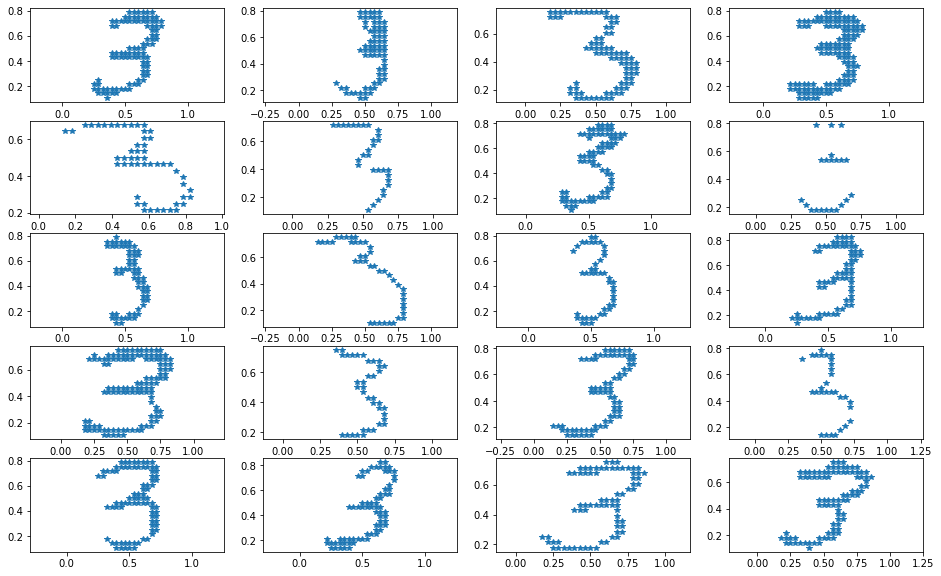

In [18]:
# Affichage des données

x = torch.load('trois.pt')

for k in range(20):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1],"*")
    plt.axis("equal")
plt.show()

In [4]:
# to do...

In [ ]:
# affichage des résultats

N = len(x) # N=20
plt.figure(figsize=(16,20))
for k in range(N):
    plt.subplot(5,4,k+1)
    plt.plot(x[k][:,0],x[k][:,1],"k*")
    plt.plot(xbar.detach()[:,0],xbar.detach()[:,1],"b*")
    p,q = Shooting(p0[k],xbar,Kv)
    plt.plot(q.detach()[:,0],q.detach()[:,1],"r*")
    plt.axis([0,1,0,1])
plt.show()